## Weather Data Network



In [1]:
import torch
import abc
from torch.autograd import Variable

from abc import ABC
from sklearn.model_selection import train_test_split


# The linear model which implemented by pytorch
class TorchLinearModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLinearModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [2]:
# The abstract optimizer model which should have model, optimizer, and criterion
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(5):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
#             print(y_pred.shape)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2) 
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()
    
    
# The Linear optimizer model which implemented by pytorch    
class TorchLinearOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLinearOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLinearOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)

In [3]:
# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u

    
# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u

In [4]:
import random
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import datetime as dt
import geopy.distance
import networkx as nx
from fmiopendata.wfs import download_stored_query

# read in raw data which has been downloaded from FMI 

data = pd.read_csv('FMIData.csv')
data = data.dropna(axis=0)
# determine number of different weather stations for which observations are available 

num_stations = len(data.station.unique())
# data.groupby(by='station').count()
print(num_stations)

203


In [5]:
def get_dist(graph,nodeA,nodeB):
    """calculate the distance between two different stations"""
    coord_1 = graph.nodes[nodeA]['coord']
    coord_2 = graph.nodes[nodeB]['coord']
    return geopy.distance.geodesic(coord_1, coord_2).miles

def add_edges(graph,total_neigh=4):
    num_nodes = graph.number_of_nodes()
    
    for i in range(num_nodes):
            node_dists = []
            '''
            a list containing the distance between node i and other nodes of the graph
            '''
            for j in range(num_nodes):
                if j == i:
                    continue
                node_dists.append(get_dist(graph,i, j))

            # sort node_dists in order to pick the nearest nodes to the node i 
            node_dists.sort(reverse=False)
            node_cnt = 0
            for j in range(num_nodes):

                if node_cnt >= total_neigh:
                    break

                if j == i:
                    continue

                # calculate the distance between node i and j of the graph
                dist = get_dist(graph,i, j)
                if dist == 0 or dist >= node_dists[total_neigh]:
                    continue
                node_cnt += 1
                graph.add_edge(i, j)
                graph.edges[i,j]['dist']=dist
    return graph

In [6]:
G_FMI = nx.Graph()
G_FMI.add_nodes_from(range(0,num_stations))

In [7]:
def get_B_weight_vec(G):
    N = G.number_of_nodes()
    E = G.number_of_edges()
    '''
    N: total number of nodes
    E: total number of edges
    '''


    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''

    cnt = 0
    for i, j in G.edges:
        B[cnt, i] = 1
        B[cnt, j] = -1

        weight_vec[cnt] = 1/G.edges[i,j]['dist']
        cnt += 1
    return B, weight_vec

In [8]:
# add node attributes: station name,feature, and label
def set_up_graph(G_FMI):
    
    for i,station in enumerate(data.station.unique()):
        df = data[data.station==station]
        G_FMI.nodes[i]['name'] = station   # name of the i-th weather station
        G_FMI.nodes[i]['coord'] = (df.latitude.unique()[0],df.longitude.unique()[0]) # coordinates of i-th weather station 
        features =df.min_temp.to_numpy()
        dummy = np.ones(features.shape[0])

        features = np.vstack((features,dummy)).T


        label = df.max_temp.to_numpy()
        X_train, X_val, y_train, y_val = train_test_split(features, label, test_size=0.33,random_state=42)

        G_FMI.nodes[i]['X_train']= Variable(torch.from_numpy(X_train)).to(torch.float32)

        G_FMI.nodes[i]['y_train'] =Variable(torch.from_numpy(y_train)).to(torch.float32)  # label vector for local dataset at node i

        G_FMI.nodes[i]['X_val']= Variable(torch.from_numpy(X_val)).to(torch.float32)

        G_FMI.nodes[i]['y_val'] =Variable(torch.from_numpy(y_val)).to(torch.float32)  # label vector for local dataset at node i

        G_FMI.nodes[i]['model'] = TorchLinearModel(2)
        G_FMI.nodes[i]['optimizer'] = TorchLinearOptimizer(G_FMI.nodes[i]['model'])
    return G_FMI

In [9]:
G_FMI = set_up_graph(G_FMI)

In [10]:
# train local models by using only local datapoints
val_errors_local = []
train_errors_local = []
for i in range(G_FMI.number_of_nodes()):
    model =  G_FMI.nodes[i]['model']
    optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss(reduction='mean')
    X_train = G_FMI.nodes[i]['X_train']
    y_train = G_FMI.nodes[i]['y_train'].reshape(-1,1)
    for j in range(250):
        prediction = model(X_train)
        loss = criterion(prediction, y_train) 
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
    train_errors_local.append(loss.detach().numpy())
    val_errors_local.append(criterion(model(G_FMI.nodes[i]['X_val']), G_FMI.nodes[i]['y_val'].reshape(-1,1)).detach().numpy())
    

123


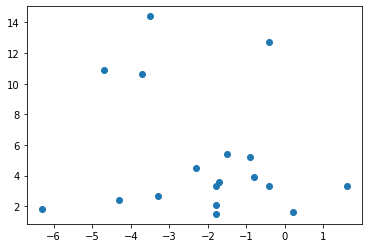

In [11]:
#visulize data points for a random selected station
i = random.randint(0,202)
print(i)
plt.scatter(G_FMI.nodes[i]['X_train'][:,0],G_FMI.nodes[i]['y_train'])


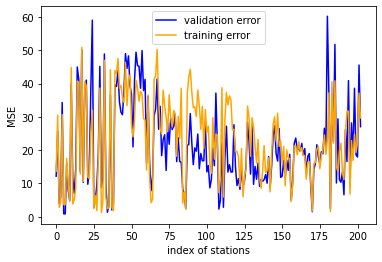

In [12]:
# visulize validation errors and training errors of locally trained models
plt.plot(val_errors_local,color='blue',label='validation error')
plt.plot(train_errors_local,color='orange',label='training error')
plt.xlabel('index of stations')
plt.ylabel('MSE')
plt.legend()

In [13]:
# # for each node, calculate the val_error by using models from all the other nodes. 
# for i in range(203):
#     val_errors=[]
#     for j in range(203):
#         model =  G_FMI.nodes[j]['model']
#         criterion = torch.nn.MSELoss(reduction='mean')
#         X = G_FMI.nodes[i]['X']
#         y = G_FMI.nodes[i]['y']
#         prediction = model(X)
#         loss = criterion(prediction, y).detach().item()
#         val_errors.append(loss)
        
#     # sort the val_errors and choose the index of the lowest 2 val_errors as neighbors, i.e. adding an edge 
#     for k in np.argsort(val_errors)[:2]: 
#         if k!=i:
#             G_FMI.add_edge(i, k)
            

In [14]:
G_FMI = set_up_graph(G_FMI)
G_FMI = add_edges(G_FMI,total_neigh=4)

B, weight_vec = get_B_weight_vec(G_FMI)

<function matplotlib.pyplot.show(*args, **kw)>

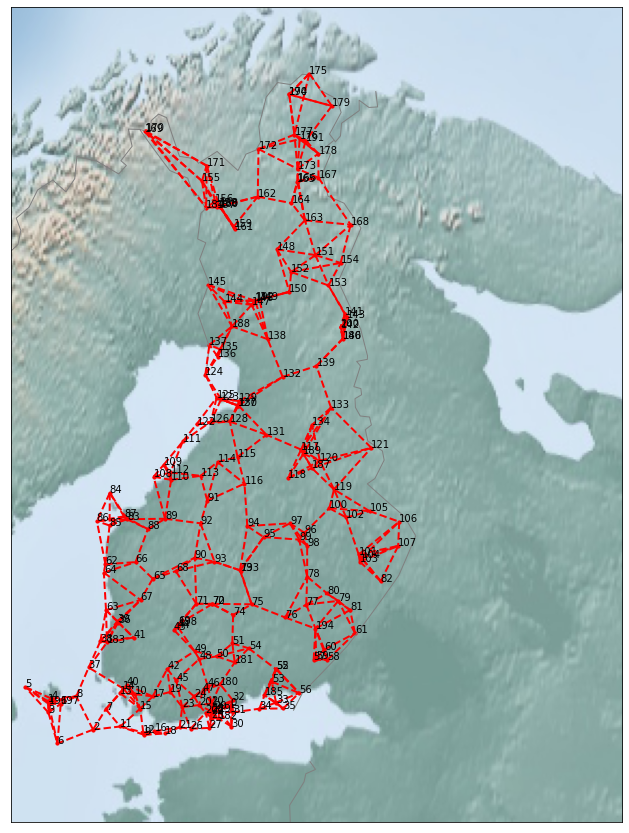

In [15]:
#visulize on the map
import mpl_toolkits
from mpl_toolkits.basemap import Basemap

from geopy.geocoders import Nominatim
import math

coords = [G_FMI.nodes[i]['coord'] for i in range(num_stations)]
df_coords = pd.DataFrame(coords,columns=['latitude','longitude'])

coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
#print(coords)

#figure = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(20,15))

#fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='l', 
            lat_0=64.8238, lon_0=28.2179,
            width=1.05E6, height=1.4E6)
m.shadedrelief()
m.drawcountries(color='gray',linewidth=1)
m.drawstates(color='gray')
x, y = m(df_coords["longitude"].to_numpy(), df_coords["latitude"].to_numpy())  # transform coordinates
ax.scatter(x, y, 10, marker='o', color='Red')

for i, txt in enumerate(df_coords.index):
    ax.annotate(txt, (x[i], y[i]))

for edge_dmy in G_FMI.edges:
    ax.plot([x[edge_dmy[0]],x[edge_dmy[1]]],[y[edge_dmy[0]],y[edge_dmy[1]]],'r--',lw=2)
    
plt.show

In [16]:
def algorithm_1(K, D, weight_vec, G, lambda_lasso, penalty_func_name='norm1'):
    '''
    :param K: the number of iterations 
    :param D: the block incidence matrix 
    :param weight_vec: a list containing the edges's weights of the graph
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set 
    :param lambda_lasso: the parameter lambda 
    :param penalty_func_name: the name of the penalty function used in the algorithm
    
    
    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    
    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(B), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

    E, N = B.shape
    '''
    shape of the graph
    '''
    m, n = G.nodes[0]['X_train'].shape
    '''
    shape of the feature vectors of each node in the graph
    '''

    # define the penalty function
    if penalty_func_name == 'norm1':
        penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)
    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)
    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)
    else:
        raise Exception('Invalid penalty name')

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = np.array([np.zeros(n) for i in range(E)])
    '''
    new_u: the dual variable of the algorithm 1
    '''
    
    # starting algorithm 1
    for iterk in range(K):
        # if iterk % 100 == 0:
        #     print ('iter:', iterk)
        
        prev_w = np.copy(new_w)

        # line 2 algorithm 1
        hat_w = new_w - np.dot(T_matrix, np.dot(D.T, new_u))
    
        
        for i in range(N):
            
            optimizer = G.nodes[i]['optimizer']
            
            new_w[i] = optimizer.optimize(G.nodes[i]['X_train'], 
                                          G.nodes[i]['y_train'], 
                                          hat_w[i], 
                                          node_degrees[i])
        
       
        # line 9 algortihm 1
        tilde_w = 2 * new_w - prev_w
        new_u = new_u + np.dot(Sigma, np.dot(D, tilde_w))
#         
        # line 10 algortihm 1
        new_u = penalty_func.update(new_u)


    return new_w

In [17]:
# Run lasso to train networked local models
K=500
lambda_lasso = 1
predicted_w = algorithm_1(K, B, weight_vec, G_FMI, lambda_lasso)
        

In [18]:
# calculate training errors and validation errors for networked models
from sklearn.metrics import mean_squared_error
val_errors_lasso = []
train_errors_lasso = []
for i in range(203):
    w = predicted_w[i]
    val_pred = G_FMI.nodes[i]['X_val'].numpy().dot(predicted_w[i])
    val_true = G_FMI.nodes[i]['y_val'].numpy()
    val_error = mean_squared_error(val_pred,val_true)
    val_errors_lasso.append(val_error)
    
    train_pred = G_FMI.nodes[i]['X_train'].numpy().dot(predicted_w[i])
    train_true = G_FMI.nodes[i]['y_train'].numpy()
    train_error = mean_squared_error(train_pred,train_true)
    train_errors_lasso.append(train_error)

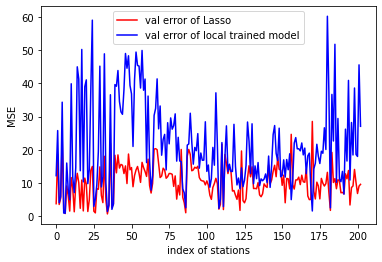

In [19]:
plt.plot(val_errors_lasso,color='r',label='val error of Lasso')
plt.plot(val_errors_local,color='b',label='val error of local trained model')
plt.xlabel('index of stations')
plt.ylabel('MSE')
plt.legend()

In [20]:
print('Average validation error of lasso:',np.mean(val_errors_lasso))
print('Average validation error of locally trained models:',np.mean(val_errors_local))

Average validation error of lasso: 10.478961195202833
Average validation error of locally trained models: 21.280682
